# Including extraction from the json label

The steps are 

- Load Metadata
    - First I load the metadata from a CSV file (final_meta_data.csv).

    - This metadata is stored in a Pandas DataFrame (`metadata`).
 
- Load COCO JSON File
    - The COCO JSON file (result.json) is loaded, which contains labeled data for some of the images.

- Create a Mapping of Image Names to Labels
    - A dictionary (image_annotations) is created to map each image file name to its corresponding animal labels by iterating through the annotations in the JSON file and linking each annotation to its image using the image_id.

    - The result is a dictionary where the key is the image file name, and the value is a list of animal labels for that image.
 
- Initialize New Columns in Metadata
    - New columns are added to the metadata DataFrame to store:

    - detected_animals: The list of detected animals.

    - animal_counts: A dictionary counting the occurrences of each detected animal.

    - confidence_scores: A dictionary of average confidence scores for each detected animal.

    - source: A column to indicate whether the detection came from the label ("label") or inference ("inference").
 
- Load the YOLO Model
    - The YOLO model is loaded
    
    - This model will be used to run inference on images that are not labeled in the JSON file.
 
- Define the Inference Function
    - The function run_inference_and_update_metadata processes each image in the metadata DataFrame.

    - For each image:

    - It checks if the image exists in the image_annotations dictionary (i.e., if it has a label in the JSON file).

    - If the image is labeled, it uses the label from the JSON file and sets the confidence score to 1.0.

    - If the image is not labeled, it runs inference using the YOLO model to detect animals.

    - The results (detected animals, counts, confidence scores, and source) are added to the metadata DataFrame.

### For first 1000

In [5]:
import os
import json
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm 
import cv2

metadata_path = "final_meta_data.csv"
metadata = pd.read_csv(metadata_path)


images_dir = "/home/jovyan/__ANIMALS/images"

# Load COCO JSON file
coco_json_path = "result.json"
with open(coco_json_path, "r") as f:
    coco_data = json.load(f)

# Create a dictionary to map image file names to their annotations
image_annotations = {}
for annotation in coco_data["annotations"]:
    image_id = annotation["image_id"]
    image_info = next(img for img in coco_data["images"] if img["id"] == image_id)
    # Normalize the image name by removing the prefix
    full_file_name = image_info["file_name"]
    image_name = full_file_name.split("__")[-1]  # Extract the part after "__"
    category_id = annotation["category_id"]
    category_name = next(cat["name"] for cat in coco_data["categories"] if cat["id"] == category_id)
    if image_name not in image_annotations:
        image_annotations[image_name] = []
    image_annotations[image_name].append(category_name)

# Output column names
metadata["detected_animals"] = None 
metadata["animal_counts"] = None  
metadata["confidence_scores"] = None  
metadata["source"] = None 

# Load YOLO model
model_path = "/home/jovyan/__ANIMALS/datasets/Y9_AUTO_FIN/runs/detect/YOLO_8s_fin/weights/best.pt"
model = YOLO(model_path)

# Class names
class_names = [
    "badger", "boar", "brown_bear", "hare", "lynx", "musk_deer", "otter", "red_fox",
    "red_squirrel", "roe_deer_female", "roe_deer_male", "sable", "sika_deer_female",
    "sika_deer_male", "tiger", "ussuri_bear", "wild_cat", "wolf", "wolverine", "yellow_marten", "raccoon"
]

# Function to run inference and update metadata
def run_inference_and_update_metadata(metadata, images_dir, model, class_names, image_annotations, max_images=1000):
    processed_count = 0
    failed_images = []
    
    # Determine total number of images to process
    total_images = len(metadata) if max_images is None else min(max_images, len(metadata))
    
    # Create a single progress bar
    pbar = tqdm(total=total_images, desc="Processing Images", unit="image")
    
    try:
        for idx, row in metadata.iterrows():
            # Stop after processing max_images
            if max_images is not None and processed_count >= max_images:
                break
            
            img_name = row["name"]
            img_path = os.path.join(images_dir, img_name)
            
            # Check if the image exists
            if not os.path.exists(img_path):
                failed_images.append(img_name)
                pbar.set_postfix_str(f"⚠️ {img_name[:20]} not found")
                pbar.update(1)
                continue
            
            # Check if the image is in the COCO JSON file
            if img_name in image_annotations:
                # Use the label from the JSON file
                detected_animals = image_annotations[img_name]
                animal_counts = {animal: detected_animals.count(animal) for animal in set(detected_animals)}
                avg_confidence_scores = {animal: 1.0 for animal in detected_animals}  # Confidence is 1.0 for labeled data
                source = "label"
            else:
                # Run inference
                try:
                    results = model(img_path, verbose=False)  # Perform inference on the image
                except Exception as e:
                    failed_images.append(img_name)
                    pbar.set_postfix_str(f"❌ Error on {img_name[:20]}")
                    pbar.update(1)
                    continue
                
                # Extract results
                detected_classes = []
                detected_scores = []
                for result in results:
                    for box in result.boxes:
                        cls = int(box.cls)  # Class index
                        conf = float(box.conf)  # Confidence score
                        detected_classes.append(cls)
                        detected_scores.append(conf)
                
                # Handle case where no animals are detected
                if not detected_classes:
                    detected_animals = ["no animal detected"]
                    animal_counts = {"no animal detected": 1}
                    avg_confidence_scores = {"no animal detected": 0.0}
                else:
                    # Map class indices to class names
                    detected_animals = [class_names[cls] for cls in detected_classes]
                    # Count occurrences of each animal and average confidence scores
                    animal_counts = {}
                    confidence_scores = {}
                    for animal, score in zip(detected_animals, detected_scores):
                        if animal not in animal_counts:
                            animal_counts[animal] = 0
                            confidence_scores[animal] = []
                        animal_counts[animal] += 1
                        confidence_scores[animal].append(score)
                    # Calculate average confidence for each animal
                    avg_confidence_scores = {animal: sum(scores)/len(scores) for animal, scores in confidence_scores.items()}
                source = "inference"
            
            # Update metadata
            metadata.at[idx, "detected_animals"] = ", ".join(detected_animals)
            metadata.at[idx, "animal_counts"] = str(animal_counts)
            metadata.at[idx, "confidence_scores"] = str(avg_confidence_scores)
            metadata.at[idx, "source"] = source
            
            
            processed_count += 1
            pbar.set_postfix_str(f"✅ {img_name[:20]}")
            pbar.update(1)
        
    except KeyboardInterrupt:
        print("\nInference interrupted by user. Saving progress...")
    
    finally:
        pbar.close()
        
        # Print summary
        print(f"\nCompleted processing {processed_count} images.")
        print(f" - Successful: {processed_count}")
        if failed_images:
            print(f" - Failed: {len(failed_images)}")
            for img in failed_images[:5]:  # Show first 5 failed images
                print(f"   - {img}")
            if len(failed_images) > 5:
                print(f"   - ...and {len(failed_images)-5} more")
        
        return metadata


# Run inference and update metadata for all images (or a subset)
print("Starting inference process...")
updated_metadata = run_inference_and_update_metadata(
    metadata, images_dir, model, class_names, image_annotations, max_images=None  # Set to None to process all images
)

# Save updated metadata to a NEW CSV file (do not overwrite the original)
output_metadata_path = "updated_predictions.csv"
updated_metadata.to_csv(output_metadata_path, index=False)
print(f"\nInference completed. Updated metadata saved to '{output_metadata_path}'.")

Starting inference process...


Processing Images: 100%|██████████| 7054/7054 [21:53<00:00,  5.37image/s, ✅ Uss-61.Komarovkarock]  



Completed processing 7054 images.
 - Successful: 7054

Inference completed. Updated metadata saved to 'updated_predictions.csv'.


# Load and inspect

In [1]:
import pandas as pd
import ast  


predictions = pd.read_csv("updated_predictions.csv")


predictions.head(5)

,name,shape,metadata,date,time,temperature,detected_animals,animal_counts,confidence_scores,source
0,Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG,"(1536, 2048, 3)",SEELOCK #01 M 17/12/2023 15:00:21 -19°C,17/12/2023,15:00:21,-19.0,lynx,{'lynx': 1},{'lynx': 1.0},label
1,Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG,"(1536, 2048, 3)",SEELOCK #01 W 21/12/2023 09:22:24 -26°C,21/12/2023,09:22:24,-26.0,sika_deer_female,{'sika_deer_female': 1},{'sika_deer_female': 1.0},label
2,Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG,"(1536, 2048, 3)",SEELOCK #01 M 22/12/2023 15:40:26 -19°C,22/12/2023,15:40:26,-19.0,sika_deer_female,{'sika_deer_female': 1},{'sika_deer_female': 1.0},label
3,Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG,"(1536, 2048, 3)",SEELOCK #01 M 22/12/2023 15:41.12 -18°C,22/12/2023,15:41:00,-18.0,"sika_deer_female, sika_deer_female",{'sika_deer_female': 2},{'sika_deer_female': 1.0},label
4,Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG,"(1536, 2048, 3)",SEELOCK #01 M 08/01/2024 19:13:17 -15°C,08/01/2024,19:13:17,-15.0,lynx,{'lynx': 1},{'lynx': 1.0},label


In [2]:
predictions.columns

Index(['name', 'shape', 'metadata', 'date', 'time', 'temperature',
       'detected_animals', 'animal_counts', 'confidence_scores', 'source'],
      dtype='object')

In [7]:
predictions.info

<bound method DataFrame.info of                                               name            shape  \
0     Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1     Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2     Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3     Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4       Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
...                                            ...              ...   
7049   Uss-43.1.TaskaevaPad_029_3-4-2024_19-59.JPG  (1944, 2592, 3)   
7050   Uss-43.1.TaskaevaPad_030_3-8-2024_01-02.JPG  (1944, 2592, 3)   
7051  Uss-43.1.TaskaevaPad_031_3-13-2024_20-23.JPG  (1944, 2592, 3)   
7052  Uss-43.1.TaskaevaPad_032_3-21-2024_00-40.JPG  (1944, 2592, 3)   
7053  Uss-61.Komarovkarock_027_1-22-2024_05-32.JPG  (1080, 1920, 3)   

                                     metadata        date      time  \
0     SEELOCK #01 M 17/12/2023 15:00:21 -19°

In [8]:
predictions['source'].unique()

array(['label', 'inference'], dtype=object)

In [9]:
# Convert string representations of dictionaries to actual dictionaries
predictions['animal_counts'] = predictions['animal_counts'].apply(ast.literal_eval)
predictions['confidence_scores'] = predictions['confidence_scores'].apply(ast.literal_eval)


print(predictions[['animal_counts', 'confidence_scores']].head())

             animal_counts          confidence_scores
0              {'lynx': 1}              {'lynx': 1.0}
1  {'sika_deer_female': 1}  {'sika_deer_female': 1.0}
2  {'sika_deer_female': 1}  {'sika_deer_female': 1.0}
3  {'sika_deer_female': 2}  {'sika_deer_female': 1.0}
4              {'lynx': 1}              {'lynx': 1.0}


In [10]:
print(predictions['animal_counts'].tail(15))

7039    {'wolf': 1, 'sable': 1, 'musk_deer': 1, 'badge...
7040                                         {'tiger': 1}
7041                                         {'tiger': 1}
7042                                         {'tiger': 1}
7043                                         {'sable': 1}
7044                              {'lynx': 1, 'tiger': 1}
7045        {'red_squirrel': 1, 'red_fox': 1, 'tiger': 1}
7046                            {'no animal detected': 1}
7047                                         {'tiger': 1}
7048                                         {'tiger': 1}
7049                                         {'tiger': 1}
7050                                          {'boar': 2}
7051                                         {'sable': 1}
7052                                        {'badger': 1}
7053                            {'no animal detected': 1}
Name: animal_counts, dtype: object


In [11]:
# column for the total number of animals detected
predictions['total_animals'] = predictions['animal_counts'].apply(
    lambda x: 0 if list(x.keys()) == ['no animal detected'] else sum(x.values())
)

# column for the average confidence score
predictions['avg_confidence'] = predictions['confidence_scores'].apply(
    lambda x: sum(x.values()) / len(x) if x else 0
)


predictions[['name', 'detected_animals', 'total_animals', 'avg_confidence']].tail(15)

,name,detected_animals,total_animals,avg_confidence
7039,Uss-40.1.Rakovka-MalayaRakovka_256_2-12-2024_1...,"wolf, sable, musk_deer, badger, sika_deer_male",5,0.466339
7040,Uss-42.1.Komagorov_057_1-19-2024_22-36.JPG,tiger,1,0.889000
7041,Uss-42.1.Komagorov_058_1-19-2024_22-36.JPG,tiger,1,0.864007
7042,Uss-42.1.Komagorov_059_1-19-2024_22-36.JPG,tiger,1,0.861365
7043,Uss-43.1.TaskaevaPad_003_12-31-2023_23-00.JPG,sable,1,0.795998
7044,Uss-43.1.TaskaevaPad_023_2-18-2024_02-24.JPG,"lynx, tiger",2,0.468187
7045,Uss-43.1.TaskaevaPad_024_2-18-2024_02-24.JPG,"red_squirrel, red_fox, tiger",3,0.422769
7046,Uss-43.1.TaskaevaPad_025_2-22-2024_04-23.JPG,no animal detected,0,0.000000
7047,Uss-43.1.TaskaevaPad_026_2-29-2024_21-25.JPG,tiger,1,0.417614
7048,Uss-43.1.TaskaevaPad_027_2-29-2024_22-50.JPG,tiger,1,0.327041


### Aggregate Data for Insights

In [12]:
import pandas as pd
import ast

# Load the predictions CSV file
predictions = pd.read_csv("updated_predictions.csv")


if predictions['animal_counts'].apply(type).eq(str).any():
    predictions['animal_counts'] = predictions['animal_counts'].apply(ast.literal_eval)

# Flatten the animal counts into separate columns

animal_counts_expanded = predictions['animal_counts'].apply(pd.Series).fillna(0)

# Add the expanded animal counts back to the original DataFrame
predictions = pd.concat([predictions, animal_counts_expanded], axis=1)

# Add a column for the total number of animals detected
predictions['total_animals'] = predictions['animal_counts'].apply(
    lambda x: sum(x.values()) if isinstance(x, dict) else 0
)


predictions['avg_confidence'] = predictions['confidence_scores'].apply(
    lambda x: sum(x.values()) / len(x) if isinstance(x, dict) and x else 0
)

# Drop rows where 'no animal detected' is the only key
predictions = predictions[predictions['total_animals'] > 0]

# Save the preprocessed data to a new CSV file
preprocessed_data_path = "preprocessed_predictions.csv"
predictions.to_csv(preprocessed_data_path, index=False)
print(f"Preprocessed data saved to '{preprocessed_data_path}'.")

Preprocessed data saved to 'preprocessed_predictions.csv'.


In [13]:
processed =  pd.read_csv("preprocessed_predictions.csv")

In [14]:
processed.head()

,name,shape,metadata,date,time,temperature,detected_animals,animal_counts,confidence_scores,source,...,roe_deer_male,otter,ussuri_bear,brown_bear,raccoon,hare,red_squirrel,wolf,total_animals,avg_confidence
0,Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG,"(1536, 2048, 3)",SEELOCK #01 M 17/12/2023 15:00:21 -19°C,17/12/2023,15:00:21,-19.0,lynx,{'lynx': 1},{'lynx': 1.0},label,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG,"(1536, 2048, 3)",SEELOCK #01 W 21/12/2023 09:22:24 -26°C,21/12/2023,09:22:24,-26.0,sika_deer_female,{'sika_deer_female': 1},{'sika_deer_female': 1.0},label,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG,"(1536, 2048, 3)",SEELOCK #01 M 22/12/2023 15:40:26 -19°C,22/12/2023,15:40:26,-19.0,sika_deer_female,{'sika_deer_female': 1},{'sika_deer_female': 1.0},label,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG,"(1536, 2048, 3)",SEELOCK #01 M 22/12/2023 15:41.12 -18°C,22/12/2023,15:41:00,-18.0,"sika_deer_female, sika_deer_female",{'sika_deer_female': 2},{'sika_deer_female': 1.0},label,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
4,Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG,"(1536, 2048, 3)",SEELOCK #01 M 08/01/2024 19:13:17 -15°C,08/01/2024,19:13:17,-15.0,lynx,{'lynx': 1},{'lynx': 1.0},label,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [1]:
import pandas as pd


processed = pd.read_csv("preprocessed_predictions.csv")


# Exclude non-animal columns like 'name', 'shape', 'metadata', etc.
non_animal_columns = [
    "name", "shape", "metadata", "date", "time", "temperature", 
    "detected_animals", "animal_counts", "confidence_scores", 
    "source", "total_animals", "avg_confidence"
]
animal_columns = [col for col in processed.columns if col not in non_animal_columns]

# Calculate the total counts for each animal
animal_summary = processed[animal_columns].sum().sort_values(ascending=False).reset_index()
animal_summary.columns = ['animal', 'count']

print(animal_summary)

                animal   count
0      roe_deer_female  2634.0
1     sika_deer_female  2037.0
2                tiger  1402.0
3                 boar   665.0
4               badger   541.0
5   no animal detected   468.0
6       sika_deer_male   403.0
7                 lynx   345.0
8        roe_deer_male   319.0
9            musk_deer   243.0
10               sable   193.0
11        red_squirrel   142.0
12             red_fox   129.0
13            wild_cat    92.0
14                wolf    59.0
15             raccoon    42.0
16         ussuri_bear    25.0
17       yellow_marten    20.0
18                hare    12.0
19          brown_bear     6.0
20               otter     1.0


/tmp/ipykernel_3403/3008579381.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=animal_summary.head(10), x='count', y='animal', palette='viridis')


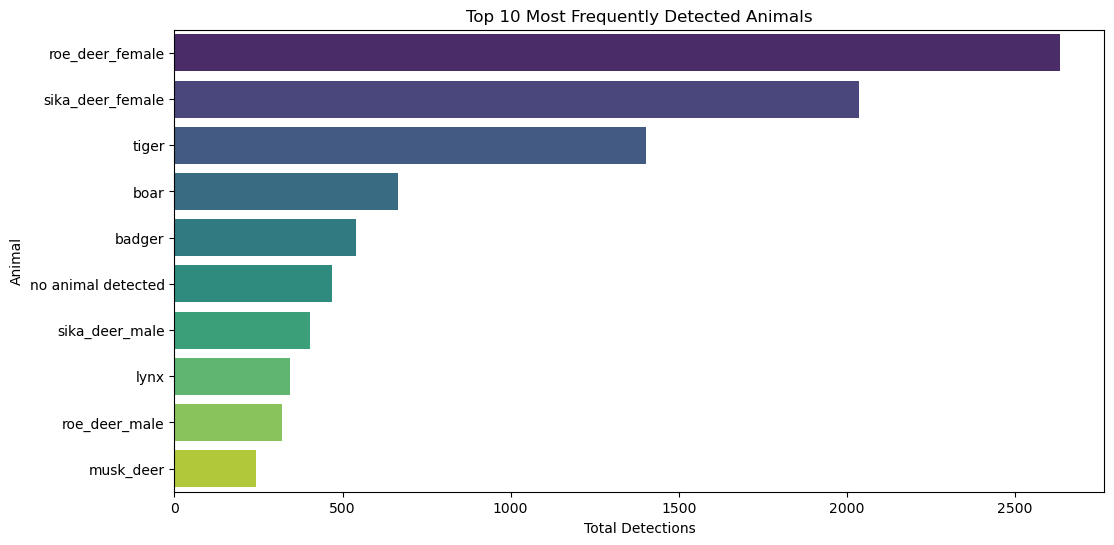

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 10 most frequently detected animals
plt.figure(figsize=(12, 6))
sns.barplot(data=animal_summary.head(10), x='count', y='animal', palette='viridis')
plt.title("Top 10 Most Frequently Detected Animals")
plt.xlabel("Total Detections")
plt.ylabel("Animal")
plt.show()

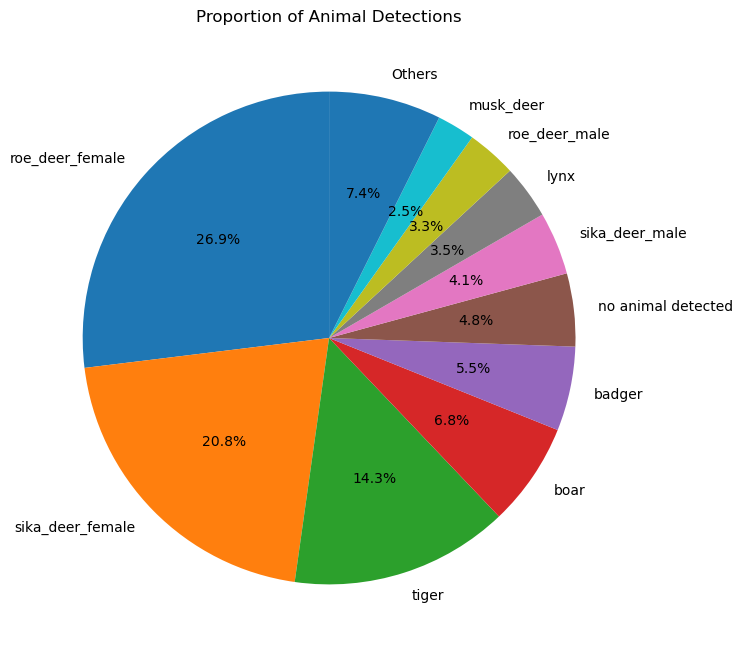

In [3]:
# Plot a pie chart for the top 10 animals and group the rest into "Others"
top_animals = animal_summary.head(10)
others_count = animal_summary['count'][10:].sum()
top_animals = pd.concat([top_animals, pd.DataFrame({'animal': ['Others'], 'count': [others_count]})])

plt.figure(figsize=(8, 8))
plt.pie(top_animals['count'], labels=top_animals['animal'], autopct='%1.1f%%', startangle=90)
plt.title("Proportion of Animal Detections")
plt.show()

/tmp/ipykernel_3403/1688573446.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  processed['date'] = pd.to_datetime(processed['date'])


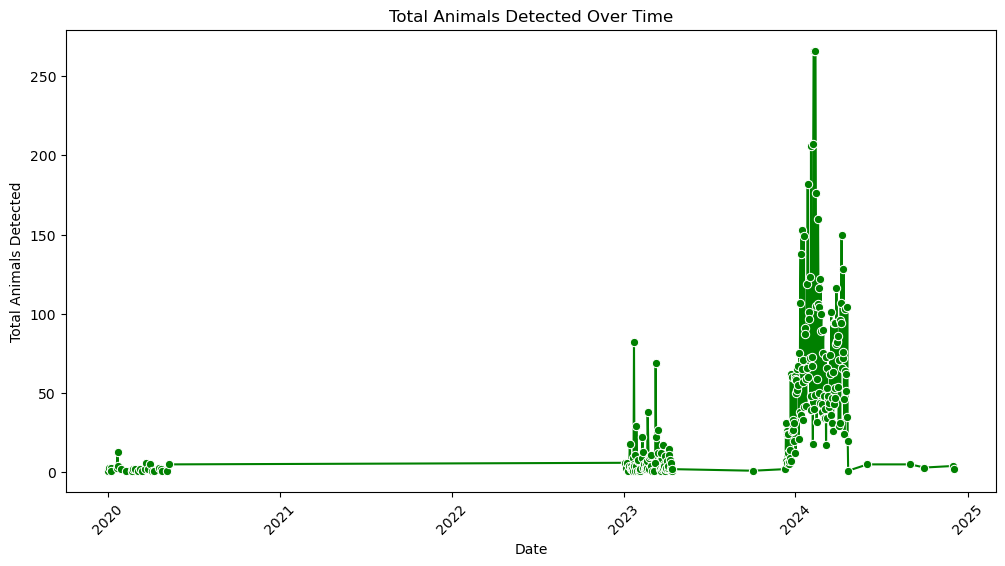

In [4]:
# Convert the 'date' column to datetime format
processed['date'] = pd.to_datetime(processed['date'])

# Group by date and calculate the total number of animals detected per day
daily_totals = processed.groupby('date')['total_animals'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_totals, x='date', y='total_animals', marker='o', color='green')
plt.title("Total Animals Detected Over Time")
plt.xlabel("Date")
plt.ylabel("Total Animals Detected")
plt.xticks(rotation=45)
plt.show()

# Building a Streamlit app for Insights

In [1]:
!pip install streamlit

  Using cached streamlit-1.44.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-manylinux2014_x86_64.whl.metadata (44 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
Using cached streamlit-1.44.1-py3-none-any.whl (9.8 MB)
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
Using cached tenacity-9.1.2-py3-none-any.whl (28 kB)
Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
Using cached watchdog-6.0.0-py3-none-manylinux2014_x86_64.whl (79 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import streamlit as st
import plotly.express as px

In [ ]:
import os

PORT = 20001
print(f'Streamlit available at: https://jhas01.gsom.spbu.ru{os.environ["JUPYTERHUB_SERVICE_PREFIX"]}proxy/{PORT}/')
!streamlit run /home/jovyan/__ANIMALS/datasets/stapp.py --server.port {PORT} --browser.gatherUsageStats False

Streamlit available at: https://jhas01.gsom.spbu.ru/user/st081121/proxy/20001/

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:20001
  Network URL: http://10.112.128.181:20001
  External URL: http://158.160.67.247:20001

/home/jovyan/__ANIMALS/datasets/stapp.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['time'].astype(str)).dt.hour
